In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad
import math
import scipy
from pyteomics import pepxml
import random
import os
import glob
from collections import deque
import pickle
import importlib as imp
import lower as low
import random
imp.reload(low)
lows = low.Tools()

In [2]:
def expectation(x, N0, a, alpha):

    t1 = pow(N0, 1+alpha)
    t2 = math.factorial(alpha)*a
    exp1 = np.exp((1+alpha)*x/a - N0*np.exp(x/a))

    expect = -x*(t1/t2)*exp1

    return expect

In [3]:
def num_int(n0, a, alpha):
    #n0 = 500
    #a = -0.02
    #alpha = 0
    integral, error = quad(expectation, 0, np.inf, args=(n0, a, alpha))
    return integral

In [38]:
es = []
for i in range(10):
    es.append(num_int(500, -0.02, i))

In [16]:
#numerically calculate the bias of my MLE estimator
p1s = []
p2s = []

for i in range(1000):
    sample = lows.gumbel_ppf(st.uniform.rvs(0, 1, 12000), 500, -0.02)
    cur_n0, cur_a = lows.mle_universal(sample, 0)
    p1s.append(cur_n0)
    p2s.append(cur_a)

In [26]:
print(np.mean(p1s), np.mean(p2s))
print(100*abs(np.mean(p1s) - 500)/500)


500.1194720920679 -0.020004889915460764
0.023894418413578932


/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


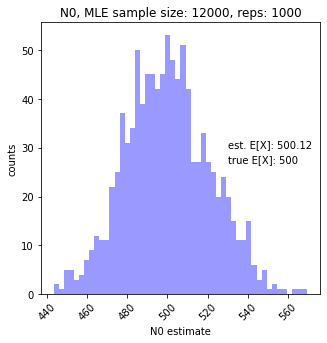

In [24]:
fig = plt.figure(figsize=(5,5))
par = "N0"
sns.distplot(p1s, bins = 50, kde=False, norm_hist=False,
                hist_kws=dict(histtype='stepfilled', linewidth=1, color='blue'))
plt.text(x=530, y=30, s=f"est. E[X]: {np.mean(p1s):.2f}")
plt.text(x=530, y=27, s=f"true E[X]: 500")
#plt.text(x=-0.02042, y=40, s=f"est. E[X]: {np.mean(p2s):.4f}")
#plt.text(x=-0.02042, y=37, s=f"true E[X]: -0.02")
plt.title(f"{par}, MLE sample size: 12000, reps: 1000")
plt.xlabel(f"{par} estimate")
plt.xticks(rotation=45)
plt.ylabel("counts")
plt.savefig(f"./graphs/{par}_12000.png", dpi=600,bbox_inches='tight')

In [4]:
def finite_gumbel_ppf(x, p, n0, a, N):

    eq1 = N*np.log(1 - (n0/N)*np.exp(x/a)) - np.log(p)
    return eq1

def fin_gumbel_ppf(x, p, n0, a, N):

    eq1 = N*np.log(1 - (n0/N)*np.exp(x/a)) - np.log(p)
    return eq1

In [5]:
def get_root(p, big_n):
    root = fsolve(finite_gumbel_ppf, x0=0.12, args=(p, 500, -0.02, big_n,))[0]
    true_root = lows.gumbel_ppf(p, 500, -0.02)
    error = 100*abs(root-true_root)/true_root
    return (root, true_root, error)

In [121]:
results50 = np.array(list(map(lambda x: get_root(x), np.linspace(0.01, 0.999, 100))))

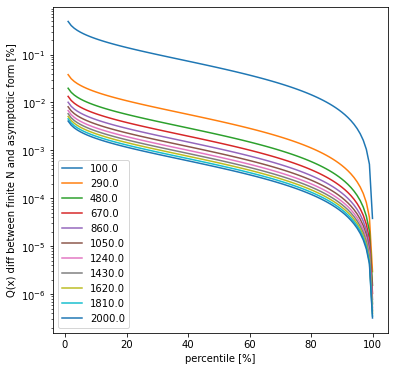

In [6]:
fig1 = plt.figure(figsize=(6,6))

for big_n in np.linspace(100, 12000, 11):
    results = np.array(list(map(lambda x: get_root(x, big_n), np.linspace(0.01, 0.999, 100))))
    plt.semilogy(100*np.linspace(0.01, 0.9999, 100), results[:,2])

plt.xlabel("percentile [%]")
plt.ylabel("ARQUE [%]")
plt.legend(np.linspace(100, 2000, 11))
plt.savefig("./graphs/finite_n_new.png", dpi=600, bbox_inches='tight')



In [2]:
def get_mix_sample(x):
    no = 10000
    cand = st.norm.rvs(12000, 1000, no)
    unis = np.random.rand(no)
    mix_sample = np.zeros(no)

    for i in range(len(cand)):
        cur_n = int(cand[i])
        cur_p = unis[i]
        cur_point = fsolve(finite_gumbel_ppf, x0=0.12, args=(cur_p, 500, -0.02, cur_n,))[0]
        mix_sample[i] = cur_point

    p1, p2 = lows.mle_universal(mix_sample, 0)
    return p1, p2

In [243]:
mix_params = np.array(list(map(get_mix_sample, range(10))))

In [247]:
np.mean(mix_params[:,0])

503.4355403046723

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

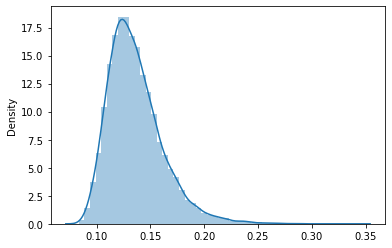

In [228]:
lows.mle_universal(mix_sample, 0)

(534.2941260608558, -0.019855788382032377)

In [219]:
np.random.rand(2)

array([0.94671547, 0.51248658])

In [192]:
big_n = 50
results2 = np.array(list(map(lambda x: get_root(x, big_n), st.uniform.rvs(0, 1, 20000))))

/tmp/ipykernel_1119600/3496455096.py:3: RuntimeWarning: invalid value encountered in log
  eq1 = N*np.log(1 - (n0/N)*np.exp(x/a)) - np.log(p)
/data/dominik/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

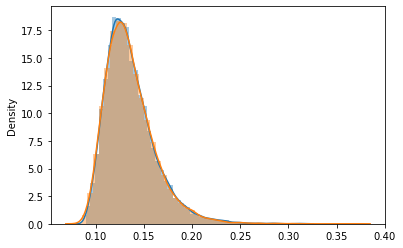

In [194]:
sns.distplot(results2[:,0])
sns.distplot(results1[:,0])

In [247]:
def n_m1_cdf(x1, p):

    x = np.exp(x1)
    eq1 = np.log(2*x - p)
    return eq1


def mle_cdf1(p):
    res = scipy.optimize.minimize(
    fun=n_m1_cdf,
    x0=np.array([-2]),
    args=(p,),
        method='BFGS'
    )
    
    opt_x = np.exp(res.x)

    return opt_x

In [2]:
#generate big sample from the underlying distribution 20k per sample
#extract first 10 hits
#store each of them, then use MLE on them and see the trend in params

def under_ppf(p, a, N0, N):
    return a*( np.log((N/N0)*(1-p)) )

#big sample
big_uni = st.uniform.rvs(0, 1, 20000)
big_under = under_ppf(big_uni, -0.02, 500, 20000)
big_under = sorted(big_under)

In [3]:
ss = 20000
samples = 50000
scores = np.zeros((ss,10))

for i in range(ss):
    if i % 1000 == 0: print(i)    
    
    random.seed()
    big_uni = st.uniform.rvs(0, 1, samples)
    big_under = under_ppf(big_uni, -0.02, 500, samples)
    big_under = sorted(big_under)
    scores[i,:] = big_under[-10:]



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.2)

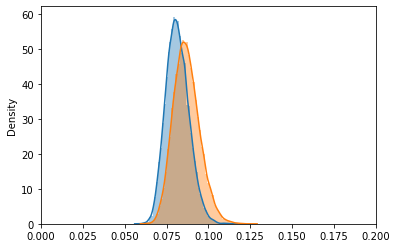

In [4]:
sns.distplot(scores[:,1])
sns.distplot(scores[:,3])
plt.xlim(0, 0.2)

In [23]:
#1 objective 1: estimate parameters for each hit separately, then plot the linear regression
def lower_params(arr):
    n0 = []
    a = []

    for hit in range(10):
        print(hit)
        cur_tev = arr[:,hit].astype('float128')
        cur_n0, cur_a = lows.mle_universal(cur_tev, 9-hit)
        n0.append(cur_n0)
        a.append(cur_a)
    return n0, a

def plot_fitted(arr, N0, a, alpha, col='blue', frac=1, outname=""):
    sorted_arr = np.array(sorted(arr))
    l_lim = sorted_arr[0]
    u_lim = sorted_arr[-1]
    fig = plt.figure(figsize=(6,6))
    pdf = lows.pdf_universal(sorted_arr, N0, a, alpha)
    plt.plot(sorted_arr, frac*pdf,color=col)
    sns.distplot(sorted_arr, bins = np.linspace(0, 0.8, 500), kde=False, norm_hist=True,
                hist_kws=dict(histtype='step', linewidth=0.5, color='black'))
    plt.xlim(l_lim, u_lim)
    plt.xlabel("TEV score")
    plt.ylabel('density')
    fig.savefig(f'./graphs/{outname}.png', dpi=400, bbox_inches='tight')
    

def plot_params(n0, a, outname = ""):

    trim_n0 = list(n0)
    trim_a = list(a)
    linreg = st.linregress(trim_n0, trim_a)
    print(linreg)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(trim_n0, trim_a, marker='*', color='royalblue')
    plt.plot([min(trim_n0), max(trim_n0)], 
                [min(trim_n0)*linreg.slope + linreg.intercept, 
                max(trim_n0)*linreg.slope + linreg.intercept], color='grey')
    plt.xlabel('N0')
    plt.ylabel("a")

    if outname != "":
        fig.savefig(f'./graphs/{outname}.png', dpi=400, bbox_inches='tight')

In [6]:
def get_params(tevs):
    n0, a = lower_params(tevs)
    trim_n0 = list(n0)[3:]
    trim_a = list(a)[3:]
    linreg = st.linregress(trim_n0, trim_a)

    return n0, a, linreg

n099, a99, linreg = get_params(scores)

0
1
2
3
4
5
6
7
8
9


LinregressResult(slope=6.9137230224025866e-06, intercept=-0.02346151966861111, rvalue=0.97335755844333, pvalue=2.1346227562339313e-06, stderr=5.758169970615673e-07, intercept_stderr=0.00029479185347335766)


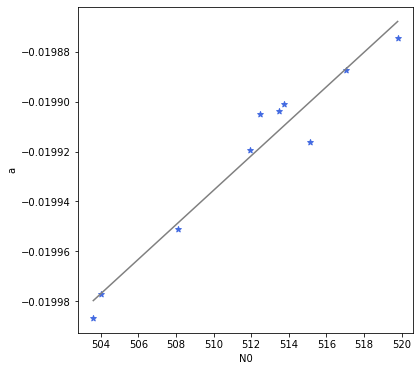

In [8]:
plot_params(n099, a99, 'simul_params')

In [17]:
a99

[-0.01999339174806027,
 -0.019970754448892764,
 -0.01996877771237862,
 -0.019946551606471494,
 -0.01998206170610013,
 -0.020059356305246287,
 -0.02007204422945811,
 -0.020073220523550712,
 -0.01988885578303696,
 -0.020107195547133225]

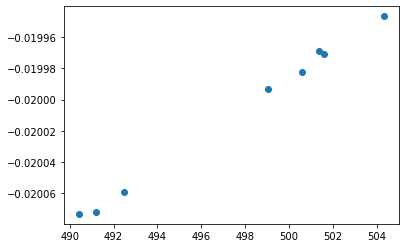

In [9]:
plt.scatter(n099[:-2], a99[:-2])

In [12]:
n1 = np.log(np.log(n099))
a1 = np.log(-np.array(a99))

In [13]:
linreg = st.linregress(n1[:-2], a1[:-2])
linreg

LinregressResult(slope=-1.2305672863884096, intercept=-1.6633392060798222, rvalue=-0.9900851197631376, pvalue=2.418618263169128e-06, stderr=0.07127492507705564, intercept_stderr=0.13045092332858668)

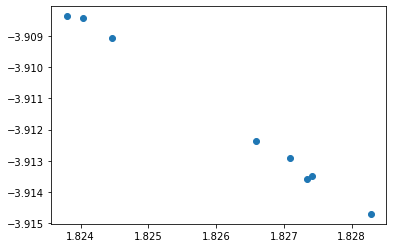

In [11]:
plt.scatter(n1[:-2], a1[:-2])

In [18]:
# generate quantiles
def get_quantiles(tev, outname):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(0.5, 3, 1000)
    for i in qq_range:
        cur_a = i*linreg.slope + linreg.intercept
        theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], np.exp(np.exp(i)), -np.exp(cur_a))
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.2])

        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    opt_a = opt_N0*linreg.slope + linreg.intercept

    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("N0")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=1)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')

    print(np.exp(np.exp(opt_N0)), -np.exp(opt_a))

    

440.50374338077796 -0.020524814615469976


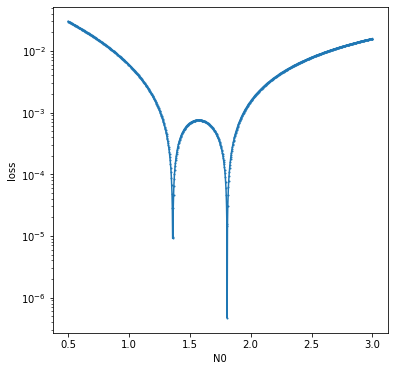

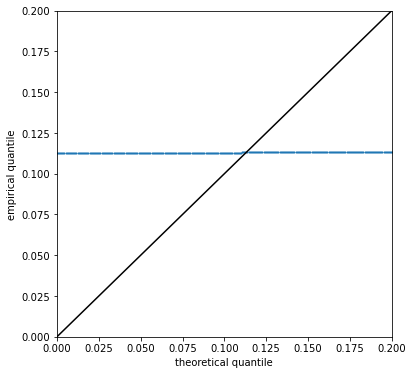

In [19]:
get_quantiles(scores[:,-1], 'test')

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


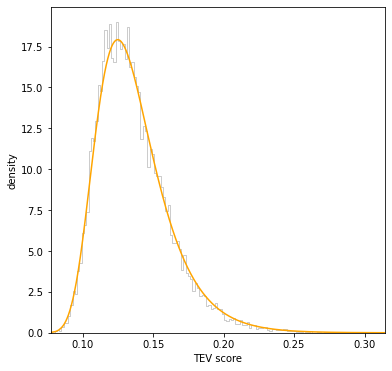

In [24]:
plot_fitted(scores[:,-1], 440.50374338077796, -0.020524814615469976, 0, col='orange', frac=1, outname='simul_0')